In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from scipy.interpolate import interp1d

In [2]:
INPUT_PATH = './example/source.png'
SOURCE_PATH = './example/target.png'

#### Import and Convert to lab

In [3]:
inputImage = cv2.imread(INPUT_PATH)
sourceImage = cv2.imread(SOURCE_PATH)

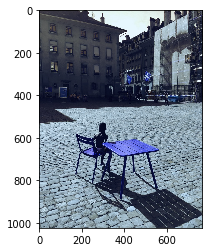

In [4]:
plt.imshow(inputImage)

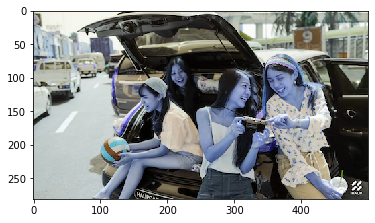

In [5]:
plt.imshow(sourceImage)

In [6]:
inputLab = cv2.cvtColor(inputImage,cv2.COLOR_BGR2LAB).astype('float32')
sourceLab = cv2.cvtColor(sourceImage,cv2.COLOR_BGR2LAB).astype('float32')

##### Constant

In [7]:
# Coarsest Scale
K = 5
# B-Min
B_MIN = 10
# B
B = 400

In [8]:
def findSMax() :
    return math.floor(math.log((B / B_MIN) , 2))

In [9]:
sMax = findSMax()

In [10]:
print(findSMax())

5


##### Calculate Histogram

In [11]:
sourcePlane = cv2.split(sourceLab)

In [12]:
targetPlane = cv2.split(sourceLab)

In [13]:
histSize = 400
histRange = (0, 256)
accumulate = False

In [14]:
ls_hist = cv2.calcHist(sourcePlane, [0], None, [histSize], histRange, accumulate=accumulate)
as_hist = cv2.calcHist(sourcePlane, [1], None, [histSize], histRange, accumulate=accumulate)
bs_hist = cv2.calcHist(sourcePlane, [2], None, [histSize], histRange, accumulate=accumulate)

In [15]:
lt_hist = cv2.calcHist(targetPlane, [0], None, [histSize], histRange, accumulate=accumulate)
at_hist = cv2.calcHist(targetPlane, [1], None, [histSize], histRange, accumulate=accumulate)
bt_hist = cv2.calcHist(targetPlane, [2], None, [histSize], histRange, accumulate=accumulate)

In [16]:
LabsHist = [ls_hist,as_hist,bs_hist]

In [17]:
LabtHist = [lt_hist,at_hist,bt_hist]

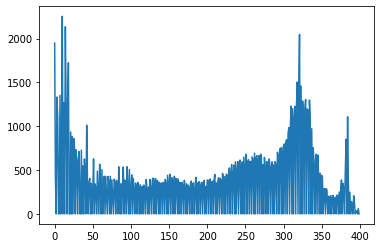

In [18]:
plt.plot(ls_hist)

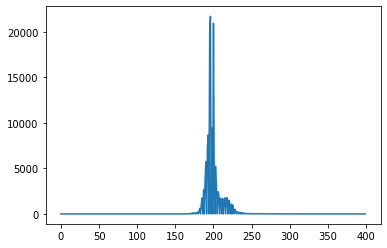

In [19]:
plt.plot(as_hist)

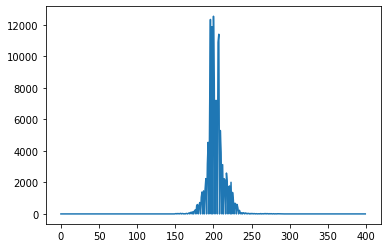

In [20]:
plt.plot(bs_hist)

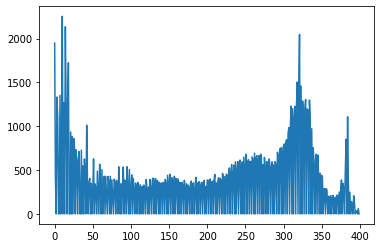

In [21]:
plt.plot(lt_hist)

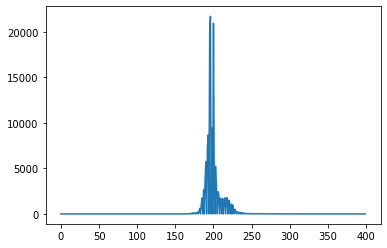

In [22]:
plt.plot(at_hist)

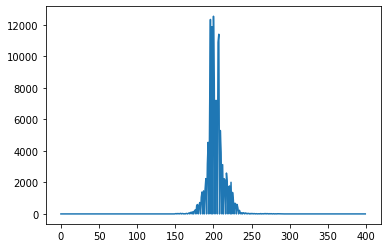

In [23]:
plt.plot(bt_hist)

#### Sampling histogram

In [24]:
def samplingHistogram(histogram):
    return upSampling(downSampling(histogram))

In [25]:
def downSampling(histogram):
    x = np.arange(400)
    y = histogram.flatten()
    bicublic = interp1d(x, y,'cubic')
    downSampling = bicublic(x)
    return np.array(downSampling, ndmin=2)

In [26]:
def upSampling(histogram):
    x = np.arange(400)
    y = histogram.flatten()
    nnInterpolate = interp1d(x, y,'nearest')
    upSampling = nnInterpolate(x)
    return shapingSampling(upSampling)

In [27]:
def shapingSampling(histogram):
    result = []
    for x in histogram:
        result.append(x)
    result = np.array(result, ndmin=1)
    return result

#### Find Peak

In [28]:
def findPeak(histogram, k, s, b):
    RminSet = []
    for i in range(0,histogram.size-1):
        if( (findDifH(histogram,k,s,i,b)*findDifH(histogram,k,s,i+1,b) > 0) 
           and findSecondDifH(histogram,k,s,i,b) > 0) :
            RminSet.append(i)
    return RminSet

In [29]:
def findDifH(histogram,k,s,i,b):    
    if(i in range(0, int(findBk(k,b,s)-1))):
        return histogram[i] - histogram[i+1]
    return 0

In [30]:
def findBk(k,b,Smax):
    return b * pow(2, (k-Smax))

In [31]:
def findSecondDifH(histogram,k,s,i,b):
    if(i in range(0, int(findBk(k,b,s)-2))):
        return 2*histogram[i+1] - histogram[i+2] - histogram[i]
    return 0

#### Region Transfer

In [32]:
def regionTransfer(Hs,Ht,wt):
    ws = 1.1-wt
    Ho = (Hs-ws*Hs.mean()) * ((wt*Ht.std())/(ws*Hs.std())) + wt*Ht.mean()
    return Ho

#### Algorithm

In [33]:
for channel in range(0,3):
    Hs = LabsHist[channel]
    Ht = LabtHist[channel]
    for k in range(1, sMax+1):
        Hs = samplingHistogram(Hs)
        Ht = samplingHistogram(Ht)
        RminT = findPeak(Ht,k,sMax, B)
        print(k)
        print(RminT)
        if(len(RminT) != 0):
            for index, minBound in enumerate(RminT):
                if(minBound != Hs.size and index != len(RminT)-1):
                    Hs[minBound:RminT[index+1]] = regionTransfer(
                        Hs[minBound:RminT[index+1]],
                        Ht[minBound:RminT[index+1]],
                        k/sMax
                    )
                    print(Hs[minBound:RminT[index+1]])
        

1
[3, 14, 16]
[ 2.96222222e+02  2.44222222e+02  0.00000000e+00  0.00000000e+00
  3.00444444e+02  0.00000000e+00  1.84000000e+02  5.00888889e+02
  0.00000000e+00  2.81555556e+02 -2.84217094e-14]
[474.22222222 270.66666667]
2
[3, 14, 16, 25, 28, 30, 39, 44]
[ 7.61714286e+02  6.28000000e+02  0.00000000e+00  0.00000000e+00
  7.72571429e+02  0.00000000e+00  4.73142857e+02  1.28800000e+03
  0.00000000e+00  7.24000000e+02 -1.13686838e-13]
[1219.42857143  696.        ]
[0.00000000e+00 7.44000000e+02 9.85142857e+02 0.00000000e+00
 0.00000000e+00 5.34285714e+02 2.84217094e-14 5.05142857e+02
 2.84217094e-14]
[492.         435.42857143   0.        ]
[417.71428571 339.42857143]
[-1.42108547e-14  3.56571429e+02  4.06857143e+02  1.42108547e-14
 -4.26325641e-14  4.14857143e+02  5.68434189e-14  3.13142857e+02
  1.42108547e-14]
[ 3.58285714e+02  2.57142857e+02 -8.52651283e-14  5.78285714e+02
  2.16571429e+02]
3
[3, 14, 16, 25, 28, 30, 39, 44, 53, 59, 63, 70, 78, 81, 84, 88, 92, 95]
[ 1.59960000e+03  1.3

/Users/tharitpongsaneh/SeniorProject/senior-project/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
